In [8]:
from bigraph_viz import plot_bigraph, replace_regex_recursive, VisualizeTypes

In [9]:
plot_settings = {
    'remove_process_place_edges': True,
    'dpi': '70'
}
save_images = True
if save_images:
    plot_settings.update({
        'out_dir': 'out',
        'dpi': '100'
    })

Writing out/hierarchy


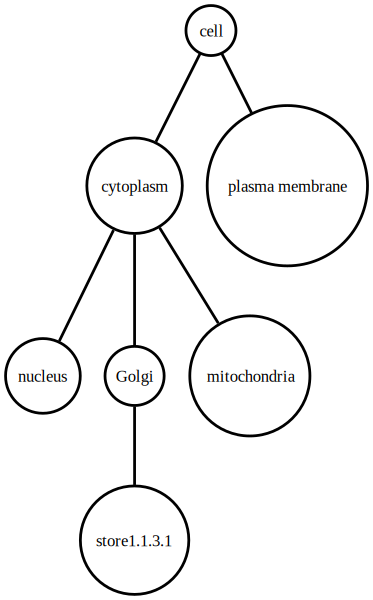

In [10]:
hierarchy_spec = {
    'cell': {
        'cytoplasm': {
            'nucleus': 'any',
            'mitochondria': 'any',
            'Golgi': {
                'store1.1.3.1': 'any',
            },
        },
        'plasma membrane': 'any',
    },
}
plot_bigraph(hierarchy_spec,
             **plot_settings,
             filename='hierarchy')

Writing out/process


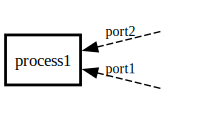

In [11]:
process_spec = {
    'process1': {
        '_type': 'edge',
        '_inputs': {
            'port1': 'any',
            'port2': 'any',
        },
    },
}
plot_bigraph(process_spec,
             **plot_settings,
             rankdir='RL',
             filename='process')

Writing out/multiple_processes


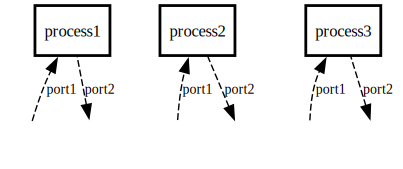

In [12]:
process_schema = {
    '_type': 'process',
    '_inputs': {
        'port1': 'Any',
    },
    '_outputs': {
        'port2': 'Any'
    },
}

processes_spec = {
    'process1': process_schema,
    'process2': process_schema,
    'process3': process_schema,
}
plot_bigraph(processes_spec,
             **plot_settings,
             rankdir='BT',
             filename='multiple_processes')

Writing out/wires


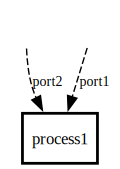

In [13]:
connected_process_spec = {
    'process1': {
        '_type': 'edge',
        '_inputs': {
            'port1': 'float',
            'port2': 'integer',
            'port3': 'integer',
        },
        'inputs': {
            'port1': ['node1'],
            'port2': ['node2'],
            'port3': ['node3'],
        }
    },
    'node1': 'float',  # TODO -- shouldn't these fill?
    'node2': 'integer',
    'node3': 'integer',
}
plot_bigraph(process_spec,
             **plot_settings,
             filename='wires')

Writing out/store


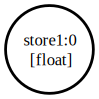

In [14]:
typed_store_spec = {
    'store1': {
        '_value': 1.0,
        '_type': 'float',
    },
}
plot_bigraph(typed_store_spec,
             **plot_settings,
             show_values=True,
             show_types=True,
             filename='store')

Writing out/flat_composite


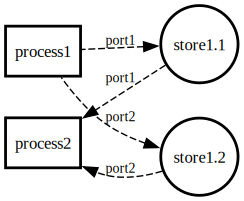

In [15]:
flat_composite_spec = {
    'store1.1': {
        '_type': 'float',
        '_value': 0.0,
    },
    'store1.2': {
        '_type': 'integer',
        '_value': 0,
    },
    'process1': {
        '_type': 'process',
        '_outputs': {
            'port1': 'float',
            'port2': 'integer',
        },
        'outputs': {
            'port1': ['store1.1'],
            'port2': ['store1.2'],
        },
    },
    'process2': {
        '_type': 'process',
        '_inputs': {
            'port1': 'float',
            'port2': 'integer',
        },
        'inputs': {
            'port1': ['store1.1'],
            'port2': ['store1.2'],
        },
    },
}
plot_bigraph(
    flat_composite_spec,
    **plot_settings,
    rankdir='RL',
    filename='flat_composite'
)


In [16]:
from process_bigraph.composite import Step, Composite,Process,ProcessEnsemble
import numpy as np

DockerException: Error while fetching server API version: ('Connection aborted.', FileNotFoundError(2, 'No such file or directory'))

In [27]:
class GillespieInterval(Step):
    config_schema = {
        'ktsc': {
            '_type': 'float',
            '_default': '5e0'},
        'kdeg': {
            '_type': 'float',
            '_default': '1e-1'}}


    def inputs(self):
        return {
            'DNA': 'map[default 1]',
            'mRNA': {
                'A mRNA': 'default 1',
                'B mRNA': 'default 1'}}

                    # {
                    # '_type': 'map',
                    # '_value': 'float(default:1.0)'},

                    # 'G': {
                    #     '_type': 'float',
                    #     '_default': '1.0'}},


    def outputs(self):
        return {
            'interval': 'interval'}


    def initial_state(self):
        return {
            'mRNA': {
                'A mRNA': 2.0,
                'B mRNA': 3.0}}


    def update(self, input):
        # retrieve the state values
        g = input['DNA']['A gene']
        c = input['mRNA']['A mRNA']

        array_state = np.array([g, c])

        # Calculate propensities
        propensities = [
            self.config['ktsc'] * array_state[0],
            self.config['kdeg'] * array_state[1]]
        prop_sum = sum(propensities)

        # The wait time is distributed exponentially
        interval = np.random.exponential(scale=prop_sum)

        output = {
            'interval': interval}

        # print(f'produced interval: {output}')

        return output


class GillespieEvent(Process):
    """stochastic toy transcription"""
    config_schema = {
        'ktsc': {
            '_type': 'float',
            '_default': '5e0'},
        'kdeg': {
            '_type': 'float',
            '_default': '1e-1'}}


    def initialize(self, config=None):
        self.stoichiometry = np.array([[0, 1], [0, -1]])


    def initial_state(self):
        return {
            'mRNA': {
                'C mRNA': 11.111},
            'DNA': {
                'A gene': 3.0,
                'B gene': 5.0}}


    def inputs(self):
        return {
            'mRNA': 'map[float]',
            'DNA': {
                'A gene': 'float',
                'B gene': 'float'}}

    def outputs(self):
        return {
            'mRNA': 'map[float]'}


    def next_reaction(self, x):
        """get the next reaction and return a new state"""

        propensities = [
            self.config['ktsc'] * x[0],
            self.config['kdeg'] * x[1]]
        prop_sum = sum(propensities)

        # Choose the next reaction
        r_rxn = np.random.uniform()
        i = 0
        for i, _ in enumerate(propensities):
            if r_rxn < propensities[i] / prop_sum:
                # This means propensity i fires
                break
        x += self.stoichiometry[i]
        return x


In [30]:
# make an instance
interval_step = GillespieInterval({})   # config uses defaults

# get its initial state
state = interval_step.initial_state()
print("Initial state:", state)

# make a fake input
input_data = {
    'DNA': {'A gene': 2.0},
    'mRNA': {'A mRNA': 1.0}
}

# call update once
output = interval_step.update(input_data)
print("Update output:", output)


Exception: must provide a core

In [28]:
def update(self, state, interval):

        # retrieve the state values, put them in array
        g = state['DNA']['A gene']
        c = state['mRNA']['A mRNA']
        array_state = np.array([g, c])

        # calculate the next reaction
        new_state = self.next_reaction(array_state)

        # get delta mRNA
        c1 = new_state[1]
        d_c = c1 - c

        update = {
            'mRNA': {
                'A mRNA': d_c}}

        # print(f'received interval: {interval}')

        return update


class GillespieSimulation(ProcessEnsemble):
    def __init__(self, config=None, core=None):
        super.__init__(config, core)


    def inputs_interval(self):
        return {
            'DNA': 'map[default 1]',
            'mRNA': {
                'A mRNA': 'default 1',
                'B mRNA': 'default 1'}}

                    # {
                    # '_type': 'map',
                    # '_value': 'float(default:1.0)'},

                    # 'G': {
                    #     '_type': 'float',
                    #     '_default': '1.0'}},


    def outputs_interval(self):
        return {
            'interval': 'interval'}


    # def interface_interval(self):


    def calculate_interval(self, inputs):
        # retrieve the state values
        g = input['DNA']['A gene']
        c = input['mRNA']['A mRNA']

        array_state = np.array([g, c])

        # Calculate propensities
        propensities = [
            self.config['ktsc'] * array_state[0],
            self.config['kdeg'] * array_state[1]]
        prop_sum = sum(propensities)

        # The wait time is distributed exponentially
        interval = np.random.exponential(scale=prop_sum)

        output = {
            'interval': interval}

        print(f'produced interval: {output}')

        return output

In [31]:
# make an instance
interval_step = GillespieInterval({})   # config uses defaults

# get its initial state
state = interval_step.initial_state()
print("Initial state:", state)

# make a fake input
input_data = {
    'DNA': {'A gene': 2.0},
    'mRNA': {'A mRNA': 1.0}
}

# call update once
output = interval_step.update(input_data)
print("Update output:", output)


Exception: must provide a core

In [32]:
# instantiate process
gillespie_proc = GillespieEvent({})

# initialize
gillespie_proc.initialize()

# get starting state
state = gillespie_proc.initial_state()
print("Initial state:", state)

# turn state into a vector for next_reaction
x = np.array([state['DNA']['A gene'], state['mRNA']['C mRNA']])

# simulate a few steps
for step in range(5):
    x = gillespie_proc.next_reaction(x)
    print(f"Step {step}, state = {x}")


Exception: must provide a core

In [33]:
class GillespieEvent:   # 👈 not inheriting from Process
    def __init__(self, config=None):
        self.config = config or {'ktsc': 5.0, 'kdeg': 0.1}
        self.stoichiometry = np.array([[0, 1], [0, -1]])

    def initial_state(self):
        return {'DNA': {'A gene': 3.0}, 'mRNA': {'C mRNA': 11.0}}

    def next_reaction(self, x):
        propensities = [
            self.config['ktsc'] * x[0],
            self.config['kdeg'] * x[1]
        ]
        prop_sum = sum(propensities)

        # pick a reaction
        r_rxn = np.random.uniform()
        for i, p in enumerate(propensities):
            if r_rxn < p / prop_sum:
                print(f"Reaction {i} fired | x before={x}")
                x += self.stoichiometry[i]
                print(f"x after={x}")
                break
        return x


import numpy as np

In [35]:
import numpy as np

In [36]:
gillespie_proc = GillespieEvent()
state = gillespie_proc.initial_state()
x = np.array([state['DNA']['A gene'], state['mRNA']['C mRNA']])

for step in range(5):
    x = gillespie_proc.next_reaction(x)
    print(f"Step {step}, state = {x}")


Reaction 0 fired | x before=[ 3. 11.]
x after=[ 3. 12.]
Step 0, state = [ 3. 12.]
Reaction 0 fired | x before=[ 3. 12.]
x after=[ 3. 13.]
Step 1, state = [ 3. 13.]
Reaction 0 fired | x before=[ 3. 13.]
x after=[ 3. 14.]
Step 2, state = [ 3. 14.]
Reaction 0 fired | x before=[ 3. 14.]
x after=[ 3. 15.]
Step 3, state = [ 3. 15.]
Reaction 0 fired | x before=[ 3. 15.]
x after=[ 3. 16.]
Step 4, state = [ 3. 16.]


Reaction 0 fired | x before=[ 3. 11.]
x after=[ 3. 12.]
Reaction 0 fired | x before=[ 3. 12.]
x after=[ 3. 13.]
Reaction 0 fired | x before=[ 3. 13.]
x after=[ 3. 14.]
Reaction 0 fired | x before=[ 3. 14.]
x after=[ 3. 15.]
Reaction 0 fired | x before=[ 3. 15.]
x after=[ 3. 16.]
Reaction 0 fired | x before=[ 3. 16.]
x after=[ 3. 17.]
Reaction 0 fired | x before=[ 3. 17.]
x after=[ 3. 18.]
Reaction 0 fired | x before=[ 3. 18.]
x after=[ 3. 19.]
Reaction 0 fired | x before=[ 3. 19.]
x after=[ 3. 20.]
Reaction 0 fired | x before=[ 3. 20.]
x after=[ 3. 21.]
Reaction 0 fired | x before=[ 3. 21.]
x after=[ 3. 22.]
Reaction 0 fired | x before=[ 3. 22.]
x after=[ 3. 23.]
Reaction 0 fired | x before=[ 3. 23.]
x after=[ 3. 24.]
Reaction 0 fired | x before=[ 3. 24.]
x after=[ 3. 25.]
Reaction 0 fired | x before=[ 3. 25.]
x after=[ 3. 26.]
Reaction 0 fired | x before=[ 3. 26.]
x after=[ 3. 27.]
Reaction 0 fired | x before=[ 3. 27.]
x after=[ 3. 28.]
Reaction 0 fired | x before=[ 3. 28.]
x after=[ 

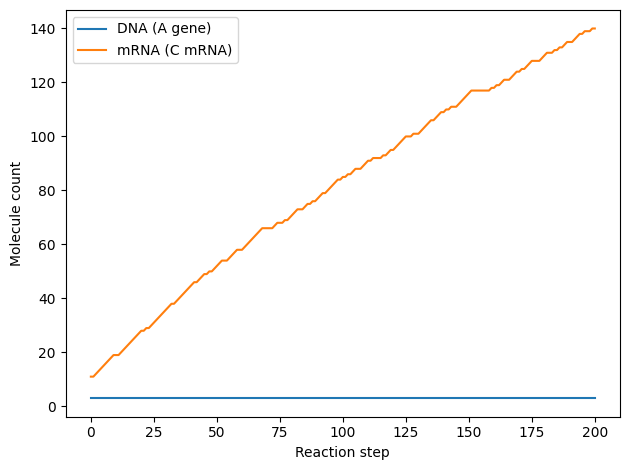

In [37]:
import numpy as np
import matplotlib.pyplot as plt

gillespie = GillespieEvent()         # your class (non-Process version)
state = gillespie.initial_state()
x = np.array([state['DNA']['A gene'], state['mRNA']['C mRNA']])

xs = [x.copy()]                      # store states
for _ in range(200):
    x = gillespie.next_reaction(x)
    xs.append(x.copy())

xs = np.array(xs)
steps = np.arange(xs.shape[0])

plt.figure()
plt.plot(steps, xs[:, 0], label='DNA (A gene)')
plt.plot(steps, xs[:, 1], label='mRNA (C mRNA)')
plt.xlabel('Reaction step')
plt.ylabel('Molecule count')
plt.legend()
plt.tight_layout()
plt.show()          # in PyCharm, this opens the SciView/plot window
# plt.savefig('trajectory_by_steps.png', dpi=300)


In [38]:
def next_reaction(self, x):
    # x = [DNA, mRNA]
    prop = np.array([
        self.config['ktsc'] * x[0],   # transcription
        self.config['kdeg'] * x[1],   # degradation
    ], dtype=float)
    prop_sum = prop.sum()
    if prop_sum <= 0:
        return x, np.inf  # no reactions possible

    # choose reaction with cumulative probability
    r = np.random.uniform() * prop_sum
    cum = 0.0
    fired = 0
    for i, p in enumerate(prop):
        cum += p
        if r <= cum:
            fired = i
            break

    # apply stoichiometry and SSA time step
    x = x + self.stoichiometry[fired]
    dt = np.random.exponential(1.0 / prop_sum)
    return x, dt


In [39]:
cfg = {'ktsc': 1.0, 'kdeg': 0.5}      # slower transcription, faster decay
# or
DNA0 = 1.0                             # fewer templates
# or (keep your params) run longer steps to see occasional decays


In [41]:
import numpy as np

class GillespieEvent:
    def __init__(self, config=None):
        self.config = {'ktsc': 1.0, 'kdeg': 0.5}
        if config: self.config.update(config)
        # 2 species: [DNA, mRNA]; reactions: transcribe (+mRNA), degrade (-mRNA)
        self.stoichiometry = np.array([[0, +1],
                                       [0, -1]], dtype=float)

    def initial_state(self):
        return {'DNA': {'A gene': 3.0},
                'mRNA': {'C mRNA': 11.0}}

    def next_reaction(self, x):
        # --- Make sure x is a 1D float array of length 2 ---
        x = np.asarray(x, dtype=float).reshape(-1)
        assert x.size == 2, f"state must be length-2, got {x} (size={x.size})"

        # propensities
        prop = np.array([
            self.config['ktsc'] * x[0],   # transcription
            self.config['kdeg'] * x[1],   # degradation
        ], dtype=float)

        prop_sum = prop.sum()
        if prop_sum <= 0:
            return x.copy(), np.inf

        # choose reaction by cumulative threshold
        r = np.random.uniform() * prop_sum
        fired = 0
        cum = 0.0
        for i, p in enumerate(prop):
            cum += p
            if r <= cum:
                fired = i
                break

        # state update + SSA time
        x = x + self.stoichiometry[fired]
        dt = np.random.exponential(1.0 / prop_sum)
        return x, dt


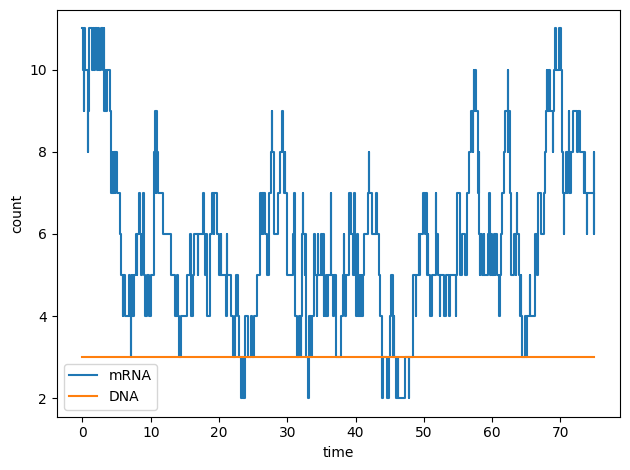

In [42]:
g = GillespieEvent(config={'ktsc': 1.0, 'kdeg': 0.5})
s0 = g.initial_state()
x = np.array([s0['DNA']['A gene'], s0['mRNA']['C mRNA']], dtype=float)

t = 0.0
times = [t]
traj = [x.copy()]

for _ in range(400):
    x, dt = g.next_reaction(x)   # <- always returns vector + dt
    t += dt
    times.append(t)
    traj.append(x.copy())

traj = np.array(traj)

import matplotlib.pyplot as plt
plt.figure()
plt.step(times, traj[:, 1], where='post', label='mRNA')
plt.step(times, traj[:, 0], where='post', label='DNA')
plt.xlabel('time'); plt.ylabel('count'); plt.legend(); plt.tight_layout(); plt.show()


In [43]:
from process_bigraph.composite import Step, Process, deep_merge


class Grow(Process):
    config_schema = {
        'rate': 'float'}

    def inputs(self):
        return {
            'mass': 'float'}

    def outputs(self):
        return {
            'mass': 'float'}

    def update(self, state, interval):
        # this calculates a delta

        return {
            'mass': state['mass'] * self.config['rate'] * interval}


# TODO: build composite and divide within it

class Divide(Step):
    # assume the agent_schema has the right divide methods present
    config_schema = {
        'agent_id': 'string',
        'agent_schema': 'schema',
        'threshold': 'float',
        'divisions': {
            '_type': 'integer',
            '_default': 2}}


    def __init__(self, config, core=None):
        super().__init__(config, core)


    def inputs(self):
        return {
            'trigger': 'float'}


    def outputs(self):
        return {
            'environment': {
                '_type': 'map',
                '_value': self.config['agent_schema']}}


    # this should be generalized to some function that depends on
    # state from the self.config['agent_schema'] (instead of trigger > threshold)
    def update(self, state):
        if state['trigger'] > self.config['threshold']:
            mother = self.config['agent_id']
            daughters = [(
                f'{mother}_{i}', {
                    'state': {
                        'divide': {
                            'config': {
                                'agent_id': f'{mother}_{i}'}}}})
                for i in range(self.config['divisions'])]

            # import ipdb; ipdb.set_trace()

            # return divide reaction
            return {
                'environment': {
                    '_react': {
                        'divide': {
                            'mother': mother,
                            'daughters': daughters}}}}


def generate_bridge_wires(schema):
    return {
        key: [key]
        for key in schema
        if not key.startswith('_')}


def generate_bridge(schema, state, interval=1.0):
    bridge = {
        port: generate_bridge_wires(schema[port])
        for port in ['inputs', 'outputs']}

    config = {
        '_type': 'quote',
        'state': state,
        'bridge': bridge}

    composite = {
        '_type': 'process',
        'address': 'parallel:composite',
        'interval': interval,
        'config': config,
        'inputs': generate_bridge_wires(schema['inputs']),
        'outputs': generate_bridge_wires(schema['outputs'])}

    return composite


def grow_divide_agent(config=None, state=None, path=None):
    agent_id = path[-1]

    config = config or {}
    state = state or {}
    path = path or []

    agent_schema = config.get(
        'agent_schema',
        {'mass': 'float'})

    grow_config = {
        'rate': 0.1}

    grow_config = deep_merge(
        grow_config,
        config.get(
            'grow'))

    divide_config = {
        'agent_id': agent_id,
        'agent_schema': agent_schema,
        'threshold': 2.0,
        'divisions': 2}

    divide_config = deep_merge(
        divide_config,
        config.get(
            'divide'))

    grow_divide_state = {
        'grow': {
            '_type': 'process',
            'address': 'local:grow',
            'config': grow_config,
            'inputs': {
                'mass': ['mass']},
            'outputs': {
                'mass': ['mass']}},

        'divide': {
            '_type': 'process',
            'address': 'local:divide',
            'config': divide_config,
            'inputs': {
                'trigger': ['mass']},
            'outputs': {
                'environment': ['environment']}}}

    grow_divide_state = deep_merge(
        grow_divide_state,
        state)

    composite = generate_bridge({
        'inputs': {'mass': ['mass']},
        'outputs': agent_schema},
        grow_divide_state)

    composite['config']['bridge']['outputs']['environment'] = ['environment']
    composite['outputs']['environment'] = ['..']

    return composite

[t=6.90] DIVIDE fired: mother=cell1 daughters=['cell1_0', 'cell1_1']
[t=13.90] DIVIDE fired: mother=cell1 daughters=['cell1_0', 'cell1_1']


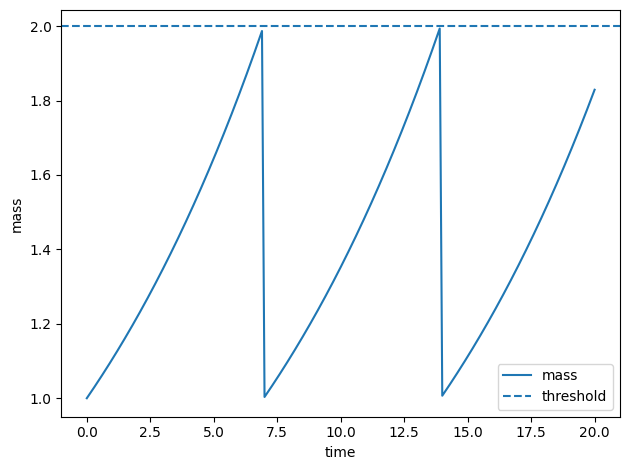

Exception: must provide a core

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from process_bigraph import register_types, ProcessTypes
import matplotlib.pyplot as plt

# --- 0) make a core and pass it to your processes ---
core = register_types(ProcessTypes())

# --- 1) instantiate your processes with the core ---
grow = Grow({'rate': 0.1}, core=core)

# IMPORTANT: agent_schema must be a valid schema (not just "float")
agent_schema = {'mass': {'_type': 'float', '_default': 1.0}}

divide = Divide({
    'agent_id': 'cell1',
    'agent_schema': agent_schema,
    'threshold': 2.0,
    'divisions': 2,
}, core=core)

# --- 2) simple manual scheduler (no engine) ---
state = {'mass': 1.0}
t, dt = 0.0, 0.1
times, masses = [t], [state['mass']]

for step in range(200):
    # Grow returns a delta to apply
    delta = grow.update({'mass': state['mass']}, dt)   # -> {'mass': d_mass}
    state['mass'] += delta['mass']

    # Divide emits a reaction when trigger crosses threshold
    out = divide.update({'trigger': state['mass']})
    if out:
        rxn = out['environment'].get('_react', {}).get('divide')
        if rxn:
            print(f"[t={t:.2f}] DIVIDE fired: mother={rxn['mother']} "
                  f"daughters={[d[0] for d in rxn['daughters']]}")
            # example bookkeeping: split mass across daughters
            state['mass'] = state['mass'] / divide.config['divisions']

    t += dt
    times.append(t); masses.append(state['mass'])

# --- 3) plot ---
plt.figure()
plt.plot(times, masses, label='mass')
plt.axhline(divide.config['threshold'], ls='--', label='threshold')
plt.xlabel('time'); plt.ylabel('mass'); plt.legend(); plt.tight_layout(); plt.show()


# --- use your classes exactly as written above ---
grow   = Grow({'rate': 0.1})
divide = Divide({
    'agent_id': 'cell1',
    'agent_schema': {'mass': 'float'},
    'threshold': 2.0,
    'divisions': 2
})

# initial state
state = {'mass': 1.0}
env = {}
t, dt = 0.0, 0.1
times, masses = [t], [state['mass']]

for step in range(200):
    # grow: returns a delta
    delta = grow.update(state, dt)             # {'mass': increment}
    state['mass'] += delta['mass']

    # check divide trigger
    out = divide.update({'trigger': state['mass']})
    if out:
        rxn = out['environment']['_react']['divide']
        print(f"[t={t:.2f}] DIVIDE fired: mother={rxn['mother']}, daughters={[d[0] for d in rxn['daughters']]}")
        # example post-division bookkeeping (optional)
        state['mass'] = state['mass'] / divide.config['divisions']

    # record & advance time
    t += dt
    times.append(t); masses.append(state['mass'])

# plot
plt.figure()
plt.plot(times, masses, label='mass')
plt.axhline(divide.config['threshold'], ls='--', label='threshold')
plt.xlabel('time'); plt.ylabel('mass'); plt.legend(); plt.tight_layout(); plt.show()


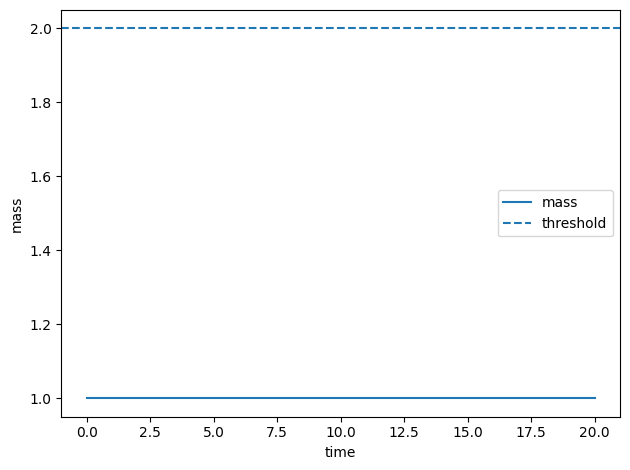

In [45]:
from process_bigraph.composite import Composite, ProcessTypes
from process_bigraph import register_types

# 1) build composite spec from your helper
agent_id = 'cell1'
spec = grow_divide_agent(
    config={'divide': {'agent_id': agent_id, 'threshold': 2.0, 'divisions': 2},
            'grow':   {'rate': 0.1}},
    state=None,
    path=('env', agent_id)  # path used by your builder to name the agent
)

# 2) make a core and composite
core = register_types(ProcessTypes())
comp = Composite(spec, core=core)

# 3) provide initial state for the bridge inputs
state = {
    'mass': 1.0,           # the input of the bridge
    'environment': {}      # where Divide will emit the _react:divide
}

# 4) tiny manual scheduler: call the composite in fixed dt
t, dt = 0.0, 0.1
masses, times = [state['mass']], [t]

for step in range(200):
    updates = comp.update(state=state, interval=dt)  # calls Grow + Divide via the bridge
    # apply returned deltas to the Python dict state
    # (Composite.update usually returns nested deltas; here we handle the simple keys)
    if 'mass' in updates:
        state['mass'] += updates['mass']  # Grow’s delta

    if 'environment' in updates:
        # check for emitted divide reaction
        react = updates['environment'].get('_react', {})
        if 'divide' in react:
            info = react['divide']
            print(f"[t={t:.2f}] DIVIDE fired: mother={info['mother']}, daughters={[d[0] for d in info['daughters']]}")
            # optional bookkeeping after division
            state['mass'] = state['mass'] / spec['config']['bridge']['state']['divide']['config']['divisions']

    t += dt
    times.append(t); masses.append(state['mass'])

# 5) plot
import matplotlib.pyplot as plt
plt.figure()
plt.plot(times, masses, label='mass')
plt.axhline(2.0, ls='--', label='threshold')
plt.xlabel('time'); plt.ylabel('mass'); plt.legend(); plt.tight_layout(); plt.show()


In [48]:
# --- sRNA ↔ mRNA regulation as a process-bigraph Process (with core) ---
from process_bigraph.composite import Process
from process_bigraph import register_types, ProcessTypes
import numpy as np
import matplotlib.pyplot as plt

class SRNARegulator(Process):
    """
    Minimal sRNA regulation of a target mRNA with stress control.
    State (in one 'cell' store): s, m, c, P, S
    """
    config_schema = {
        # choose "activator" (ArcZ/DsrA/RprA on rpoS) or "repressor" (OxyS/CyaR)
        'mode': {'_type': 'string', '_default': 'activator'},

        # Hill transcription params for sRNA and mRNA vs stress S (0..1)
        'k_tx_s': {'_type': 'map', '_default': {'k0': 0.02, 'kmax': 0.30, 'K': 0.30, 'n': 2.0}},
        'k_tx_m': {'_type': 'map', '_default': {'k0': 0.05, 'kmax': 0.50, 'K': 0.40, 'n': 2.0}},

        # Hfq + pairing kinetics (simplified: H is a scalar multiplier here)
        'H':      {'_type': 'float', '_default': 1.0},
        'kon':    {'_type': 'float', '_default': 3e-4},
        'koff':   {'_type': 'float', '_default': 0.10},
        'kcleave':{'_type': 'float', '_default': 0.10},
        'krescue':{'_type': 'float', '_default': 0.05},

        # decay
        'kdeg_s': {'_type': 'float', '_default': 0.20},
        'kdeg_m': {'_type': 'float', '_default': 0.10},

        # translation control
        # activator: k_tl = ktl0 + gamma * c/(Kg + c)
        # repressor: k_tl = ktl0 / (1 + eta * c/(Ke + c))
        'ktl0':   {'_type': 'float', '_default': 0.50},
        'gamma':  {'_type': 'float', '_default': 3.0},
        'Kg':     {'_type': 'float', '_default': 50.0},
        'eta':    {'_type': 'float', '_default': 4.0},
        'Ke':     {'_type': 'float', '_default': 50.0},

        # protein degradation decreases with stress (stabilization)
        'Pdeg0':      {'_type': 'float', '_default': 0.02},
        'sigma_stab': {'_type': 'float', '_default': 0.6},
        'Kp':         {'_type': 'float', '_default': 0.3},
        'np':         {'_type': 'float', '_default': 2.0},

        # optional Rho termination relief by complex (simple switch)
        'rho_p0': {'_type': 'float', '_default': 0.40},
        'rho_delta': {'_type': 'float', '_default': 0.50},   # fraction relieved by c
        'rho_Kc': {'_type': 'float', '_default': 50.0},      # c scale
    }

    # one-port API: everything lives in 'cell'
    def inputs(self):
        return {'cell': 'map[float]'}

    def outputs(self):
        return {'cell': 'map[float]'}

    def initial_state(self):
        # You can override these from the driver if you want.
        return {'cell': {'s': 0.0, 'm': 5.0, 'c': 0.0, 'P': 0.0, 'S': 0.0}}

    # Hill helper
    @staticmethod
    def hill(k0, kmax, K, n, S):
        return k0 + kmax * (S**n) / (K**n + S**n)

    def update(self, state, interval):
        x = state['cell']  # convenience
        S = float(x.get('S', 0.0))

        # unpack config
        cfg = self.config
        k_tx_s = self.hill(**cfg['k_tx_s'], S=S)
        k_tx_m_raw = self.hill(**cfg['k_tx_m'], S=S)

        # Rho termination effect on mRNA synthesis, relieved by c
        c = x.get('c', 0.0)
        rho_relief = cfg['rho_delta'] * (c / (cfg['rho_Kc'] + c))
        p_rho = cfg['rho_p0'] * (1.0 - rho_relief)
        k_tx_m = k_tx_m_raw * (1.0 - p_rho)

        # pairing kinetics
        H  = cfg['H']
        kon, koff, kcleave, krescue = cfg['kon'], cfg['koff'], cfg['kcleave'], cfg['krescue']
        s, m = x.get('s', 0.0), x.get('m', 0.0)

        # translation control
        if cfg['mode'] == 'activator':
            ktl = cfg['ktl0'] + cfg['gamma'] * c / (cfg['Kg'] + c)
            kcleave_eff = kcleave
        else:  # repressor
            ktl = cfg['ktl0'] / (1.0 + cfg['eta'] * c / (cfg['Ke'] + c))
            kcleave_eff = kcleave * 1.5  # modestly higher decay when repressed

        # stress-dependent protein degradation
        Pdeg = cfg['Pdeg0'] * (1.0 - cfg['sigma_stab'] * (S**cfg['np']) / (cfg['Kp']**cfg['np'] + S**cfg['np']))
        P = x.get('P', 0.0)

        # ODEs (mass-action + simple controls)
        ds = k_tx_s - (kon*H*s*m) + koff*c - cfg['kdeg_s']*s
        dm = k_tx_m - (kon*H*s*m) + koff*c - cfg['kdeg_m']*m
        dc = (kon*H*s*m) - (koff + kcleave_eff + krescue)*c
        dP = (ktl * m) - Pdeg*P

        # return deltas (Euler)
        return {'cell': {
            's': ds*interval,
            'm': dm*interval,
            'c': dc*interval,
            'P': dP*interval,
            # expose S unchanged so a driver can overwrite it each step
            'S': 0.0
        }}


# ---------------------- Driver with core + stress pulse ----------------------
# 1) Core (required)
core = register_types(ProcessTypes())

# 2) Instantiate the process (choose mode: 'activator' or 'repressor')
srna = SRNARegulator({'mode': 'activator'}, core=core)

# 3) Initial state
state = srna.initial_state()
state['cell'].update({'s': 0.0, 'm': 5.0, 'c': 0.0, 'P': 0.0, 'S': 0.0})

# 4) Run with a stress step: S=0 until t=5, then S=1
t, dt = 0.0, 0.05
T_end = 20.0

times = [t]
traj_s, traj_m, traj_c, traj_P, traj_S = [[state['cell'][k]] for k in ('s','m','c','P','S')]

while t < T_end:
    # set stress
    state['cell']['S'] = 0.0 if t < 5.0 else 1.0

    # step process
    delta = srna.update({'cell': state['cell']}, dt)
    for k in ('s','m','c','P'):
        state['cell'][k] += delta['cell'][k]  # Euler update

    # record
    t += dt
    times.append(t)
    traj_s[0].append(state['cell']['s'])
    traj_m[0].append(state['cell']['m'])
    traj_c[0].append(state['cell']['c'])
    traj_P[0].append(state['cell']['P'])
    traj_S[0].append(state['cell']['S'])

# 5) Plot
plt.figure()
plt.plot(times, traj_S[0], label='Stress S', linestyle='--')
plt.plot(times, traj_s[0], label='sRNA (s)')
plt.plot(times, traj_m[0], label='mRNA (m)')
plt.plot(times, traj_c[0], label='Complex (c)')
plt.plot(times, traj_P[0], label='Protein (P)')
plt.xlabel('time'); plt.ylabel('concentration / a.u.')
plt.legend()
plt.tight_layout()
plt.show()


AttributeError: 'float' object has no attribute 'append'

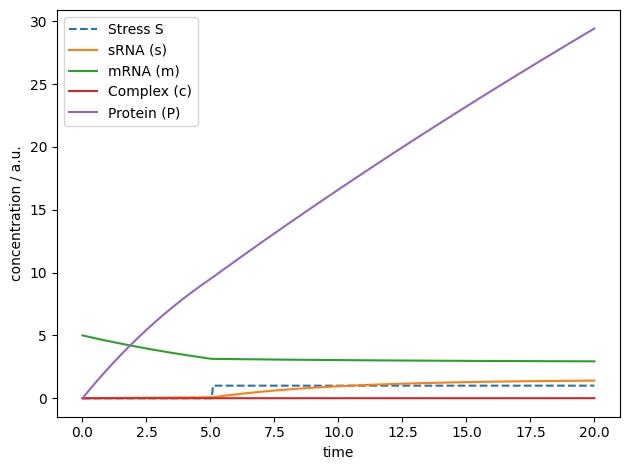

In [49]:
# --- sRNA–mRNA regulation with process-bigraph (uses core) ---
from process_bigraph.composite import Process
from process_bigraph import register_types, ProcessTypes
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------- Process ----------------------------
class SRNARegulator(Process):
    """
    Minimal sRNA regulation of a target mRNA with stress control.
    State (single 'cell' store): s, m, c, P, S
    """
    config_schema = {
        # 'activator' ~ ArcZ/DsrA/RprA on rpoS; 'repressor' ~ OxyS/CyaR
        'mode': {'_type': 'string', '_default': 'activator'},

        # Hill transcription vs stress S in [0,1]
        'k_tx_s': {'_type': 'map', '_default': {'k0': 0.02, 'kmax': 0.30, 'K': 0.30, 'n': 2.0}},
        'k_tx_m': {'_type': 'map', '_default': {'k0': 0.05, 'kmax': 0.50, 'K': 0.40, 'n': 2.0}},

        # Hfq / pairing kinetics
        'H':       {'_type': 'float', '_default': 1.0},
        'kon':     {'_type': 'float', '_default': 3e-4},
        'koff':    {'_type': 'float', '_default': 0.10},
        'kcleave': {'_type': 'float', '_default': 0.10},
        'krescue': {'_type': 'float', '_default': 0.05},

        # decay
        'kdeg_s':  {'_type': 'float', '_default': 0.20},
        'kdeg_m':  {'_type': 'float', '_default': 0.10},

        # translation control
        # activator: ktl = ktl0 + gamma*c/(Kg+c)
        # repressor: ktl = ktl0 / (1 + eta*c/(Ke+c))
        'ktl0':    {'_type': 'float', '_default': 0.50},
        'gamma':   {'_type': 'float', '_default': 3.0},
        'Kg':      {'_type': 'float', '_default': 50.0},
        'eta':     {'_type': 'float', '_default': 4.0},
        'Ke':      {'_type': 'float', '_default': 50.0},

        # stress-dependent protein stabilization
        'Pdeg0':      {'_type': 'float', '_default': 0.02},
        'sigma_stab': {'_type': 'float', '_default': 0.6},
        'Kp':         {'_type': 'float', '_default': 0.3},
        'np':         {'_type': 'float', '_default': 2.0},

        # optional Rho termination relief by complex
        'rho_p0':   {'_type': 'float', '_default': 0.40},
        'rho_delta':{'_type': 'float', '_default': 0.50},
        'rho_Kc':   {'_type': 'float', '_default': 50.0},
    }

    # one-port API (everything in one map store)
    def inputs(self):  return {'cell': 'map[float]'}
    def outputs(self): return {'cell': 'map[float]'}
    def initial_state(self):
        return {'cell': {'s': 0.0, 'm': 5.0, 'c': 0.0, 'P': 0.0, 'S': 0.0}}

    @staticmethod
    def hill(k0, kmax, K, n, S):
        return k0 + kmax * (S**n) / (K**n + S**n + 1e-12)

    def update(self, state, interval):
        x = state['cell']
        S = float(x.get('S', 0.0))
        cfg = self.config

        # transcription
        k_tx_s = self.hill(**cfg['k_tx_s'], S=S)
        k_tx_m_raw = self.hill(**cfg['k_tx_m'], S=S)

        # Rho termination relief by c
        c = x.get('c', 0.0)
        rho_relief = cfg['rho_delta'] * (c / (cfg['rho_Kc'] + c + 1e-12))
        p_rho = cfg['rho_p0'] * (1.0 - rho_relief)
        k_tx_m = k_tx_m_raw * (1.0 - p_rho)

        # pairing
        s, m = x.get('s', 0.0), x.get('m', 0.0)
        H = cfg['H']
        kon, koff = cfg['kon'], cfg['koff']
        kcleave_eff = cfg['kcleave']
        if cfg['mode'] == 'activator':
            ktl = cfg['ktl0'] + cfg['gamma'] * c / (cfg['Kg'] + c + 1e-12)
        else:  # repressor
            ktl = cfg['ktl0'] / (1.0 + cfg['eta'] * c / (cfg['Ke'] + c + 1e-12))
            kcleave_eff *= 1.5

        # stress-dependent protein degradation
        P = x.get('P', 0.0)
        Pdeg = cfg['Pdeg0'] * (1.0 - cfg['sigma_stab'] * (S**cfg['np']) / (cfg['Kp']**cfg['np'] + S**cfg['np'] + 1e-12))

        # ODEs
        ds = k_tx_s - (kon*H*s*m) + koff*c - cfg['kdeg_s']*s
        dm = k_tx_m - (kon*H*s*m) + koff*c - cfg['kdeg_m']*m
        dc = (kon*H*s*m) - (koff + kcleave_eff + cfg['krescue'])*c
        dP = (ktl * m) - Pdeg*P

        # deltas (Euler)
        return {'cell': {
            's': ds*interval,
            'm': dm*interval,
            'c': dc*interval,
            'P': dP*interval,
            'S': 0.0  # left for driver to overwrite each step
        }}

# ---------------------------- Driver ----------------------------
# Always create a core and pass it in
core = register_types(ProcessTypes())

# Choose 'activator' or 'repressor'
srna = SRNARegulator({'mode': 'activator'}, core=core)

# Initial state (you can edit these)
state = srna.initial_state()
state['cell'].update({'s': 0.0, 'm': 5.0, 'c': 0.0, 'P': 0.0, 'S': 0.0})

# Simulation settings
t, dt, T_end = 0.0, 0.05, 20.0

# Trajectories (lists!)
times = [t]
traj = {k: [state['cell'][k]] for k in ('S', 's', 'm', 'c', 'P')}

# Stress schedule: step from 0 to 1 at t = 5
while t < T_end:
    state['cell']['S'] = 0.0 if t < 5.0 else 1.0

    # Step the process
    delta = srna.update({'cell': state['cell']}, dt)
    for k in ('s', 'm', 'c', 'P'):
        state['cell'][k] += delta['cell'][k]

    # Record
    t += dt
    times.append(t)
    for k in ('S', 's', 'm', 'c', 'P'):
        traj[k].append(state['cell'][k])

# ---------------------------- Plot ----------------------------
plt.figure()
plt.plot(times, traj['S'], linestyle='--', label='Stress S')
plt.plot(times, traj['s'], label='sRNA (s)')
plt.plot(times, traj['m'], label='mRNA (m)')
plt.plot(times, traj['c'], label='Complex (c)')
plt.plot(times, traj['P'], label='Protein (P)')
plt.xlabel('time'); plt.ylabel('concentration / a.u.')
plt.legend(); plt.tight_layout(); plt.show()


In [50]:
srna

In [52]:
traj['S']

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [57]:
# --- 0) imports & core ---
from process_bigraph import register_types, ProcessTypes


core = register_types(ProcessTypes())

# --- 1) process class from earlier (already defined in your session) ---
# class SRNARegulator(Process): ...  (keep exactly as you ran before)

# --- 2) make a local instance (needed only for address binding) ---
srna_proc = SRNARegulator({'mode': 'activator'}, core=core)

# --- 3) Build a bigraph spec (typed stores + wired process) ---
bigraph_spec = {
    # Stores
    'cell': {
        '_type': 'map',
        '_value': {
            's': {'_type': 'float', '_default': 0.0},
            'm': {'_type': 'float', '_default': 5.0},
            'c': {'_type': 'float', '_default': 0.0},
            'P': {'_type': 'float', '_default': 0.0},
            'S': {'_type': 'float', '_default': 0.0},
        },
    },
    'env': {
        '_type': 'map',
        '_value': {
            'S': {'_type': 'float', '_default': 0.0},   # stress comes from env
        },
    },

    # Process node (wired to stores via ports)
    'srna': {
        '_type': 'process',
        'address': 'local:srna',           # bind to our local instance below
        'config': srna_proc.config,        # show current config on the node
        '_inputs': {
            # port types (for diagram type labels)
            'cell': 'map[float]',
        },
        '_outputs': {
            'cell': 'map[float]',
        },
        # wiring: port -> store paths
        'inputs':  {
            'cell': ['cell'],              # read the entire cell map
        },
        'outputs': {
            'cell': ['cell'],              # write deltas back to the cell map
        },
    },

    # A tiny "wire" process to copy env.S → cell.S so the graph shows S coming from env
    'stress_bridge': {
        '_type': 'process',
        'address': 'parallel:bridge',      # stock bridge copies inputs→outputs
        'config': {
            'bridge': {
                'inputs':  {'S': ['env.S']},
                'outputs': {'S': ['cell.S']},
            }
        },
        '_inputs':  {'S': 'float'},
        '_outputs': {'S': 'float'},
        'inputs':   {'S': ['env.S']},
        'outputs':  {'S': ['cell.S']},
    },
}

# --- 4) Bind local addresses to instances (so the plot shows configs nicely) ---
# (Only needed if your visualize/engine expects address→object mapping.)
address_book = {
    'local:srna': srna_proc,
}

# --- 5) Plot settings and render ---
plot_settings = dict(
    out_dir='out',
    file_format='png',      # or 'svg'
    rankdir='LR',           # left→right layout; try 'TB' for top→bottom
    show_values=True,
    show_types=True,
    scale=1.0,
)

plot_bigraph(
    state=bigraph_spec,     # you can pass as 'schema' too; helper accepts either
    **plot_settings,
    filename='srna_bigraph'
)

print("Wrote diagram to out/srna_bigraph.png")


Writing out/srna_bigraph
Wrote diagram to out/srna_bigraph.png


Writing out/srna_bigraph_expanded


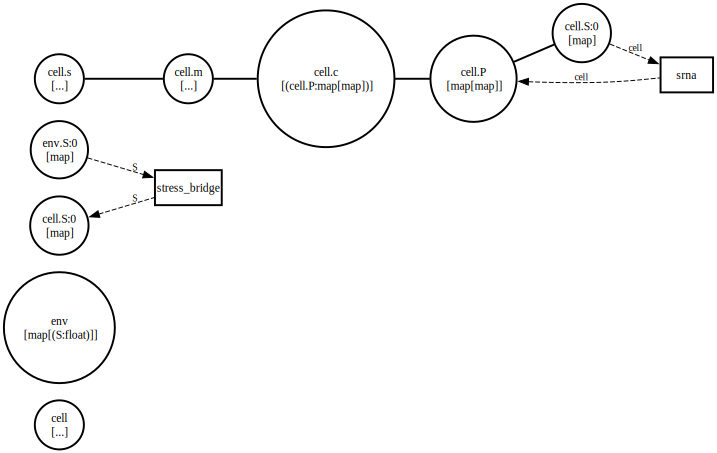

In [58]:
from process_bigraph import register_types, ProcessTypes


core = register_types(ProcessTypes())

# expand the cell map so leaves are visible
bigraph_spec = {
    'cell': {
        '_type': 'map',
        '_value': {
            's': {'_type': 'float', '_default': 0.0},
            'm': {'_type': 'float', '_default': 5.0},
            'c': {'_type': 'float', '_default': 0.0},
            'P': {'_type': 'float', '_default': 0.0},
            'S': {'_type': 'float', '_default': 0.0},
        },
    },
    'env': {
        '_type': 'map',
        '_value': {'S': {'_type': 'float', '_default': 0.0}},
    },

    # bridge: env.S -> cell.S (input dashed, output solid)
    'stress_bridge': {
        '_type': 'process',
        'address': 'parallel:bridge',
        'config': {'bridge': {'inputs': {'S': ['env.S']}, 'outputs': {'S': ['cell.S']}}},
        '_inputs': {'S': 'float'},
        '_outputs': {'S': 'float'},
        'inputs': {'S': ['env.S']},
        'outputs': {'S': ['cell.S']},
    },

    # sRNA process: read all 5 leaves, write back 4 of them
    'srna': {
        '_type': 'process',
        'address': 'local:srna',
        '_inputs': {
            'cell': 'map[float]',
        },
        '_outputs': {
            'cell': 'map[float]',
        },
        'inputs': {
            'cell': ['cell.s', 'cell.m', 'cell.c', 'cell.P', 'cell.S'],
        },
        'outputs': {
            # writes deltas to these leaves
            'cell': ['cell.s', 'cell.m', 'cell.c', 'cell.P'],
        },
    },
}

plot_bigraph(
    state=bigraph_spec,
    out_dir='out',
    filename='srna_bigraph_expanded',
    file_format='png',
    rankdir='LR',
    show_types=True,
    show_values=True,
)
